In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [7]:
df.date_time = pd.to_datetime(df.date_time)

In [14]:
df_1 = df[df['num']==1]

<Axes: >

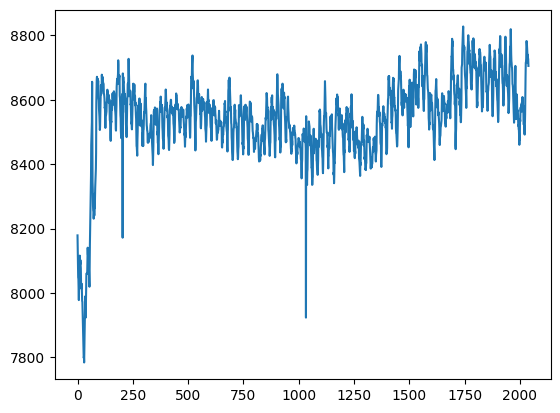

In [17]:
df_1['전력사용량(kWh)'].plot()

In [27]:
group = df.groupby(['num','date_time']).mean()

In [36]:
df[df['태양광보유'] == 1].num.unique()

array([ 3,  4,  8,  9, 12, 14, 16, 21, 23, 24, 26, 27, 30, 34, 36, 37, 38,
       39, 40, 42, 43, 44, 45, 47, 51, 52, 55, 56, 60], dtype=int64)